In [1]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2

%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import (
    remove_component,
    remove_holes,
)
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata

from skimage.morphology import skeletonize
from amftrack.util.sys import temp_path
import pandas as pd
from PIL import Image
from scipy.optimize import curve_fit
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

plt.style.use("presentation.mplstyle")

2022-11-30 14:41:58,106-[INFO]- numexpr.utils:148 -> Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-11-30 14:41:58,106-[INFO]- numexpr.utils:160 -> NumExpr defaulting to 8 threads.


/home/ipausers/bisot/pycode/MscThesis/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2022-11-30 14:42:00.217692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 14:42:01.452726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/bisot/miniconda3/envs/amftrack/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-30 14:42:01.452739: I tensorflow/stream_executor/cuda/cudart_stub.

In [7]:
images_path = r"/mnt/sun/home-folder/Kaikai/Plate705_161122"  # select images path
binning = 1
magnification = 50
space_pixel_size = 2 * 1.725 / (magnification) * binning
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path, file) for file in files]
images_total_path.sort()

/data/temp/ipykernel_2418125/816856600.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])


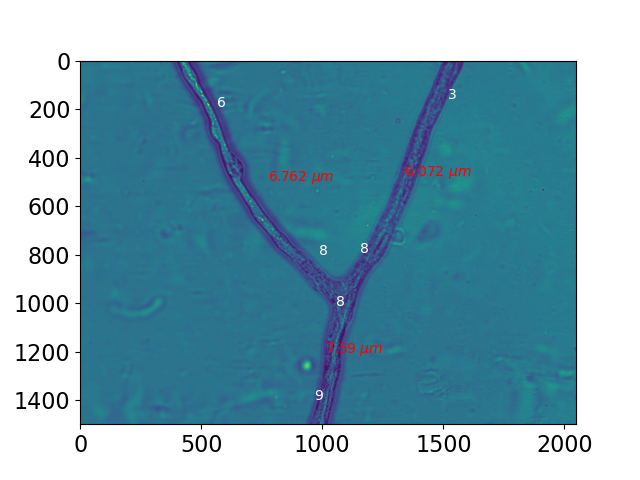

In [10]:
selection_file = images_total_path
selection_file.sort()
# select image index
begin = 1
image = imageio.imread(selection_file[begin])
file_name = selection_file[begin].split("/")[-1].split(".")[0]
segmented, nx_graph_pruned, pos = segment_brightfield(image)

edges = list(nx_graph_pruned.edges)

fig, ax = plt.subplots()
ax.imshow(image)
bound1 = 0
bound2 = 1
offset = 100
step = 30
target_length = 130
resolution = 1
weight = 0.15
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
        edge,
        pos,
        image,
        nx_graph_pruned,
        resolution=resolution,
        offset=offset,
        step=step,
        target_length=target_length,
        bound1=bound1,
        bound2=bound2,
    )
    # this is where the width for a given edge is calculated
    width = round(
        get_width_from_graph_im(edge, pos, image, nx_graph_pruned, slice_length=400)
        * space_pixel_size,
        4,
    )
    # plotting edge label

    ax.text(
        *np.flip((1 - weight) * pos[edge[0]] + weight * pos[edge[1]]),
        str(edge[0]),
        color="white",
    )
    ax.text(
        *np.flip((1 - weight) * pos[edge[1]] + weight * pos[edge[0]]),
        str(edge[1]),
        color="white",
    )
    # plotting edge width

    ax.text(
        *np.flip((1 - 0.5) * pos[edge[1]] + 0.5 * pos[edge[0]]),
        f"{width} $\mu m$",
        color="red",
    )

***doing it for all***

In [ ]:
selection_file = images_total_path
selection_file.sort()
for begin in range(1, len(selection_file)):
    image = imageio.imread(selection_file[begin])
    file_name = selection_file[begin].split("/")[-1].split(".")[0]
    segmented, nx_graph_pruned, pos = segment_brightfield(image)
    edges = list(nx_graph_pruned.edges)

    fig, ax = plt.subplots()
    ax.imshow(image)
    bound1 = 0
    bound2 = 1
    offset = 100
    step = 30
    target_length = 130
    resolution = 1
    weight = 0.15
    for edge in edges:
        slices, segments = extract_section_profiles_for_edge(
            edge,
            pos,
            image,
            nx_graph_pruned,
            resolution=resolution,
            offset=offset,
            step=step,
            target_length=target_length,
            bound1=bound1,
            bound2=bound2,
        )
        width = round(
            get_width_from_graph_im(edge, pos, image, nx_graph_pruned, slice_length=400)
            * space_pixel_size,
            4,
        )
        ax.text(
            *np.flip((1 - weight) * pos[edge[0]] + weight * pos[edge[1]]),
            str(edge[0]),
            color="white",
        )
        ax.text(
            *np.flip((1 - weight) * pos[edge[1]] + weight * pos[edge[0]]),
            str(edge[1]),
            color="white",
        )
        ax.text(
            *np.flip((1 - 0.5) * pos[edge[1]] + 0.5 * pos[edge[0]]),
            f"{width} $\mu m$",
            color="red",
        )

/data/temp/ipykernel_1725187/3577568640.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
